In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Hyperparameters
latent_size = 10
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
# Data loading
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [40]:
class VAE(nn.Module):
    # ... (Implement encoder, decoder, reparameterize, and forward methods)
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten input to 784
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  # Adjust output dimension as needed
        )
        self.fc_mu = nn.Linear(128, latent_size)
        self.fc_var = nn.Linear(128, latent_size)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    def encode(self, x):
        return self.fc_mu(self.encoder(x)), self.fc_var(self.encoder(x))

    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        recon_x = recon_x.view(-1, 1, 28, 28)  # Reshape to match input size
        return recon_x, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    reconstruction_loss = F.mse_loss(recon_x, x)
    # kl_divergence = -0.0001 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_divergence = torch.tensor(0.0)
    return reconstruction_loss + kl_divergence

In [41]:
# Initialize model and optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)

        recon_batch, mu, logvar = model(x)
        loss = loss_function(recon_batch, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

Epoch [1/10], Step [100/1875], Loss: 0.0637
Epoch [1/10], Step [200/1875], Loss: 0.0565
Epoch [1/10], Step [300/1875], Loss: 0.0531
Epoch [1/10], Step [400/1875], Loss: 0.0452
Epoch [1/10], Step [500/1875], Loss: 0.0319
Epoch [1/10], Step [600/1875], Loss: 0.0344
Epoch [1/10], Step [700/1875], Loss: 0.0321
Epoch [1/10], Step [800/1875], Loss: 0.0288
Epoch [1/10], Step [900/1875], Loss: 0.0260
Epoch [1/10], Step [1000/1875], Loss: 0.0306
Epoch [1/10], Step [1100/1875], Loss: 0.0253
Epoch [1/10], Step [1200/1875], Loss: 0.0225
Epoch [1/10], Step [1300/1875], Loss: 0.0241
Epoch [1/10], Step [1400/1875], Loss: 0.0231
Epoch [1/10], Step [1500/1875], Loss: 0.0286
Epoch [1/10], Step [1600/1875], Loss: 0.0262
Epoch [1/10], Step [1700/1875], Loss: 0.0197
Epoch [1/10], Step [1800/1875], Loss: 0.0236
Epoch [2/10], Step [100/1875], Loss: 0.0244
Epoch [2/10], Step [200/1875], Loss: 0.0219
Epoch [2/10], Step [300/1875], Loss: 0.0212
Epoch [2/10], Step [400/1875], Loss: 0.0241
Epoch [2/10], Step [500

In [42]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)

        x_hat, _, _ = model(x)

        break

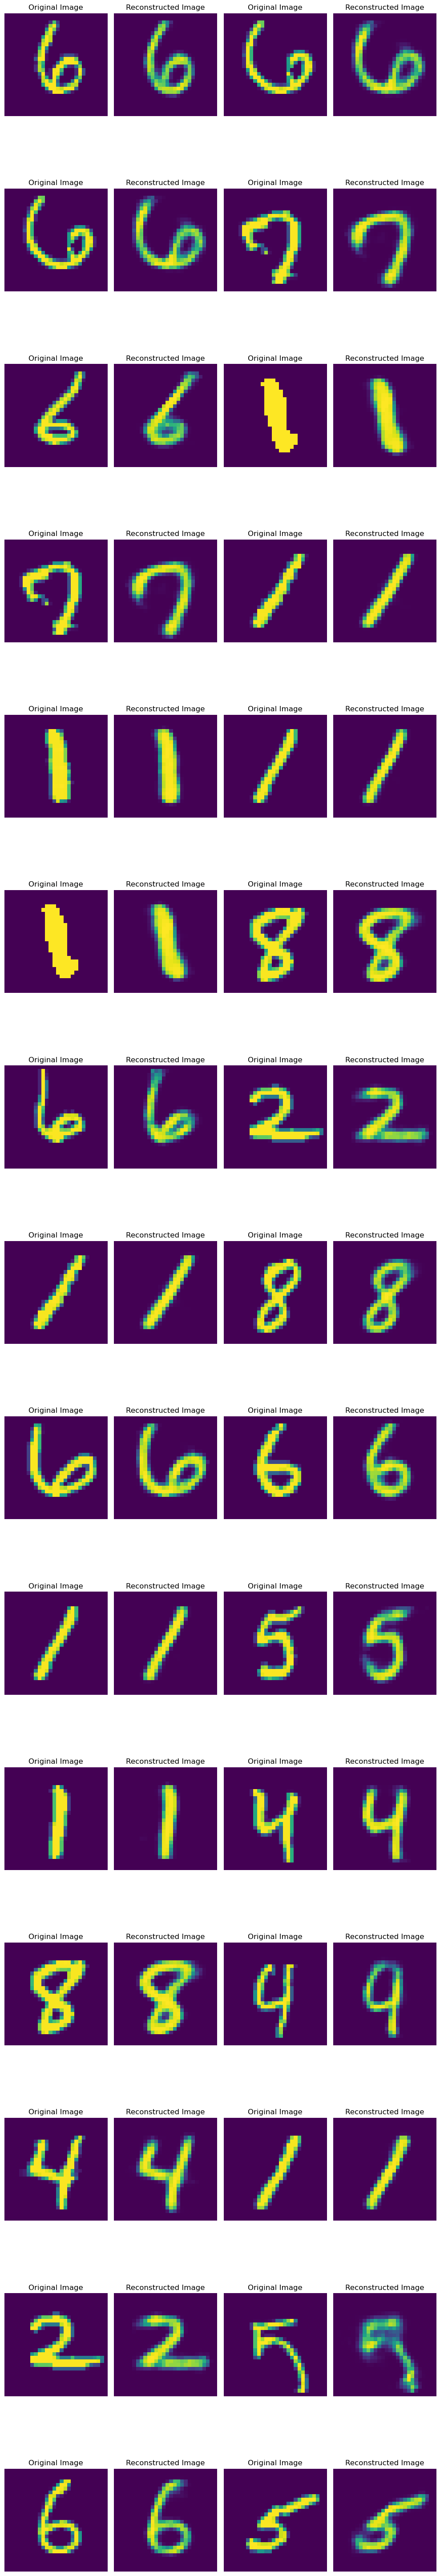

In [43]:
# make gap smaller 
fig, axes = plt.subplots(nrows=15, ncols=4, figsize=(10, 60))

for i in range(15):

    original_image = x[i].view(28, 28).cpu().numpy()
    reconstructed_image = x_hat[i].view(28, 28).cpu().numpy()
    
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_image)
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')
    j = i*2+1
    original_image = x[j].view(28, 28).cpu().numpy()
    reconstructed_image = x_hat[j].view(28, 28).cpu().numpy()

    # Add your own images or modify as per your requirement
    axes[i, 2].imshow(original_image)
    axes[i, 2].set_title('Original Image')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(reconstructed_image)
    axes[i, 3].set_title('Reconstructed Image')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()